# Sami LAITA

# TP: MNIST with Neural Networks (NN)

In [363]:
import numpy as np
import tensorflow as tf
import keras
print("Using tensorflow version " + str(tf.__version__))
print("Using keras version " + str(keras.__version__))

Using tensorflow version 2.18.0
Using keras version 3.8.0


## Loading and preparing the MNIST dataset
Load the MNIST dataset made available by keras.datasets. Check the size of the training and testing sets. 

<div class='alert alert-block alert-info'>
            Code:</div>

In [364]:
# The MNSIT dataset is ready to be imported from Keras into RAM
# Warning: you cannot do that for larger databases (e.g., ImageNet)
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print("Training images have size " + str(train_images.shape))
print("Training labels have size " + str(train_labels.shape))
print("Test images have size " + str(test_images.shape))
print("Test labels have size " + str(test_labels.shape))

Training images have size (60000, 28, 28)
Training labels have size (60000,)
Test images have size (10000, 28, 28)
Test labels have size (10000,)


The MNIST database contains 60,000 training images and 10,000 testing images.
Using the pyplot package, visualize the first sample of the training set:

<div class='alert alert-block alert-info'>
            Code:</div>

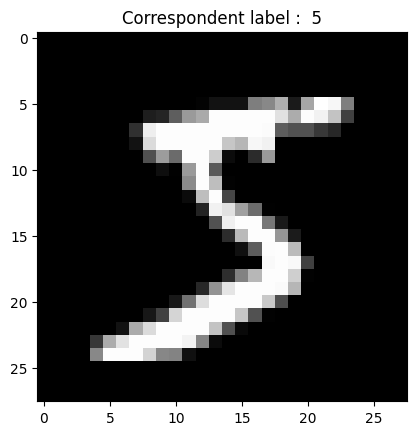

In [365]:
# Let us visualize the first training sample using the Matplotlib library with the imshow function
from matplotlib import pyplot as plt
plt.imshow(train_images[0], cmap='gray')
plt.title('Correspondent label :  ' + str(train_labels[0]))
plt.show()

The database contains images of handwritten digits. Hence, they belong to one of 10 categories, depending on the digit they represent. 
Reminder: in order to do multi-class classification, we use the softmax function, which outputs a multinomial probability distribution. That means that the output to our model will be a vector of size $10$, containing probabilities (meaning that the elements of the vector will be positive sum to $1$).
For easy computation, we want to true labels to be represented with the same format: that is what we call **one-hot encoding**. For example, if an image $\mathbf{x}$ represents the digit $5$, we have the corresponding one_hot label (careful, $0$ will be the first digit): 
$$ \mathbf{y} = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] $$
Here, you need to turn train and test labels to one-hot encoding using the following function: 

<div class='alert alert-block alert-info'>
            Code:</div>

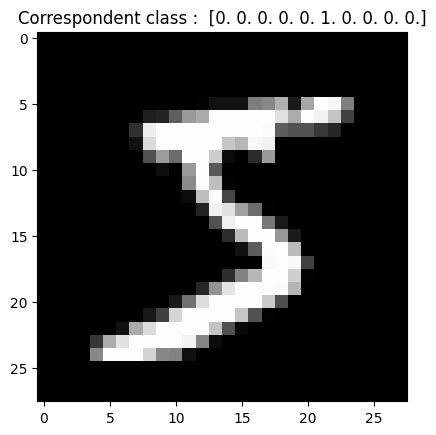

In [366]:
from keras.utils import to_categorical

# Turning the labels into one-hot encoded vectors
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

# example : 
plt.imshow(train_images[0], cmap='gray')
plt.title('Correspondent class :  ' + str(train_labels[0]))
plt.show()

Images are black and white, with size $28 \times 28$. We will work with them using a simple linear classification model, meaning that we will have them as vectors of size $(784)$.
You should then transform the images to the size $(784)$ using the numpy function ```reshape```.

Then, after casting the pixels to floats, normalize the images so that they have zero-mean and unitary deviation. Be careful to your methodology: while you have access to training data, you may not have access to testing data, and must avoid using any statistic on the testing dataset.

<div class='alert alert-block alert-info'>
            Code:</div>

For normalization we should always compute it on the training set **ONLY** that is because if we compute it on the entire dataset we will have **data leakage**. So we should compute the transformation on the training data and then apply the same transformation on the test data afterwards.

In [367]:
# Reshape images to vectors of pixels
img_rows, img_cols = train_images.shape[1], train_images.shape[2]
train_images = train_images.reshape((train_images.shape[0], img_cols*img_rows))
test_images = test_images.reshape((test_images.shape[0], img_rows * img_cols))


# Cast pixels from uint8 to float32
train_images = train_images.astype('float32')

# Now let us normalize the images so that they have zero mean and standard deviation
# Hint: are real testing data statistics known at training time ?

# we should first import the scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)

# Let us check the statistics
print("Training images have mean " + str(np.mean(train_images)) + " and std " + str(np.std(train_images)))
print("Test images have mean " + str(np.mean(test_images)) + " and std " + str(np.std(test_images)))


Training images have mean -4.528331e-10 and std 0.9563164
Test images have mean 0.002495697308915079 and std 0.9571450819920649


# First part: working with Numpy

Look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf) for some basic information on how to use numpy.

### Defining the model 

We will here create a simple, linear classification model. We will take each pixel in the image as an input feature (making the size of the input to be $784$) and transform these features with a weight matrix $\mathbf{W}$ and a bias vector $\mathbf{b}$. Since there is $10$ possible classes, we want to obtain $10$ scores. Then, 
$$ \mathbf{W} \in \mathbb{R}^{784 \times 10} $$
$$ \mathbf{b} \in \mathbb{R}^{10} $$

and our scores are obtained with:
$$ \mathbf{z} = \mathbf{W}^{T} \mathbf{x} +  \mathbf{b} $$

where $\mathbf{x} \in \mathbb{R}^{784}$ is the input vector representing an image.
We note $\mathbf{y} \in \mathbb{R}^{10}$ as the target one_hot vector. 

Here, you fist need to initialize $\mathbf{W}$ and $\mathbf{b}$ using ```np.random.normal``` and ```np.zeros```, then compute $\mathbf{z}$.
<div class='alert alert-block alert-info'>
            Code:</div>

In [368]:
# To avoid implementing a complicated gradient back-propagation,
# we will try a very simple architecture with one layer 
def initLayer(n_input,n_output):
    """
    Initialize the weights, return the number of parameters
    Inputs: n_input: the number of input units - int
          : n_output: the number of output units - int
    Outputs: W: a matrix of weights for the layer - numpy ndarray
           : b: a vector bias for the layer - numpy ndarray
           : nb_params: the number of parameters  - int
    """

    
    # Create W at the right size with a normal distribution
    W = np.random.normal(0, 1, (n_input,n_output))
    # Create b at the right size, with zeros
    b = np.zeros(n_output)
    nb_params = n_input * n_output + n_output
    return W, b, nb_params

In [369]:
n_training = train_images.shape[0] 
n_feature = train_images.shape[1]
n_labels = 10
W, b, nb_params = initLayer(n_feature, n_labels)

<div class='alert alert-block alert-info'>
            Code:</div>

In [370]:
def forward(W, b, X):
    """
    Perform the forward propagation
    Inputs: W: the weights - numpy ndarray
          : b: the bias - numpy ndarray
          : X: the batch - numpy ndarray
    Outputs: z: outputs - numpy ndarray
    """

    z = np.dot(X, W) + b
    return z

### Computing the output 

To obtain classification probabilities, we use the softmax function:
$$ \mathbf{o} = softmax(\mathbf{z}) \text{         with          } o_i = \frac{\exp(z_i)}{\sum_{j=0}^{9} \exp(z_j)} $$

The usual difficulty with the softmax function is the possibility of overflow when the scores $z_i$ are already large. Since a softmax is not affected by a shift affecting the whole vector $\mathbf{z}$:
$$ \frac{\exp(z_i - c)}{\sum_{j=0}^{9} \exp(z_j - c)} =  \frac{\exp(c) \exp(z_i)}{\exp(c) \sum_{j=0}^{9} \exp(z_j)} = \frac{\exp(z_i)}{\sum_{j=0}^{9} \exp(z_j)}$$
what trick can we use to ensure we will not encounter any overflow ? 
<div class='alert alert-block alert-info'>
            Code:</div>

$\textcolor{Red}{Answer :}$
- As the softmax is not affected by shifting we can substract from every $z_i$ the maximum value $Max(\{z_i, i\})$. Note that when we have negative values with high absolute value, this is not leading to overflow because the expo goes to zero.

In [371]:
def softmax(z):
    """
    Perform the softmax transformation to the pre-activation values
    Inputs: z: the pre-activation values - numpy ndarray
    Outputs: out: the activation values - numpy ndarray
    """
    
    if len(z.shape) > 1:
      z = z - z.max(axis=1, keepdims=True)
      out = np.exp(z) / np.exp(z).sum()
      return out
    z_shifted = z - np.max(z)
    out = np.exp(z_shifted) / np.sum(np.exp(z_shifted))
    return out

### Making updates

We define a learning rate $\eta$. The goal is to be able to apply updates:
$$ \mathbf{W}^{t+1} = \mathbf{W}^{t} + \nabla_{\mathbf{W}} l_{MLE} $$

In order to do this, we will compute this gradient (and the bias) in the function ```update```. In the next function ```updateParams```, we will actually apply the update with regularization. 

Reminder: the gradient $\nabla_{\mathbf{W}} l_{MLE}$ is the matrix containing the partial derivatives 
$$ \left[\frac{\delta l_{MLE}}{\delta W_{ij}}\right]_{i=1..784, j=1..10} $$
**Remark**: Careful, the usual way of implementing this in python has the dimensions of $\mathbf{W}$ reversed compared to the notation of the slides.

Coordinate by coordinate, we obtain the following update: 
$$ W_{ij}^{t+1} = W_{ij}^{t} + \eta \frac{\delta l_{MLE}}{\delta W_{ij}} $$

Via the chain rule, we obtain, for an input feature $i \in [0, 783]$ and a output class $j \in [0, 9]$: $$\frac{\delta l_{MLE}}{\delta W_{ij}} = \frac{\delta l_{MLE}}{\delta z_{j}} \frac{\delta z_j}{\delta W_{ij}}$$ 

It's easy to compute that $\frac{\delta z_j}{\delta W_{ij}} = x_i$

We compute the softmax derivative, to obtain:
$$ \nabla_{\mathbf{z}} l_{MLE} = \mathbf{o} - \mathbf{y} $$

Hence, $\frac{\delta l_{MLE}}{\delta z_{j}} = o_j - y_j$ and we obtain that $$\frac{\delta l_{MLE}}{\delta W_{ij}} = (o_j - y_j) x_i$$

This can easily be written as a scalar product, and a similar computation (even easier, actually) can be done for $\mathbf{b}$. Noting $\nabla_{\mathbf{z}} l_{MLE} = \mathbf{o} - \mathbf{y}$ as ```grad``` in the following function, compute the gradients $\nabla_{\mathbf{W}} l_{MLE}$ and $\nabla_{\mathbf{b}} l_{MLE}$ in order to call the function ```updateParams```.

Note: the regularizer and the weight_decay $\lambda$ are used in ```updateParams```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [372]:
def update(eta, W, b, grad, X, regularizer, weight_decay):
    """
    Perform the update of the parameters
    Inputs: eta: the step-size of the gradient descent - float 
          : W: the weights - ndarray
          : b: the bias -  ndarray
          : grad: the gradient of the activations w.r.t. to the loss -  list of ndarray
          : X: the data -  ndarray
          : regularizer: 'L2' or None - the regularizer to be used in updateParams
          : weight_decay: the weight decay to be used in updateParams - float
    Outputs: W: the weights updated -  ndarray
           : b: the bias updated -  ndarray
    """
    X=X.reshape((img_rows*img_cols, 1))
    grad=grad.reshape(1, -1)
    grad_w = X @ grad
    grad_b = grad
        
    W = updateParams(W, grad_w, eta, regularizer, weight_decay)
    b = updateParams(b, grad_b, eta, regularizer, weight_decay)
    return W, b

The update rule is affected by regularization. We implement two cases: No regularization, or L2 regularization. Use the two possible update rules to implement the following function: <div class='alert alert-block alert-info'>
            Code:</div>

In [373]:
def updateParams(param, grad_param, eta, regularizer=None, weight_decay=0.):
    """
    Perform the update of the parameters
    Inputs: param: the network parameters - ndarray
          : grad_param: the updates of the parameters - ndarray
          : eta: the step-size of the gradient descent - float
          : weight_decay: the weight-decay - float
    Outputs: the parameters updated - ndarray
    """
    if regularizer==None:
        param = param - eta * grad_param
        return param
    elif regularizer=='L2':
        param = - eta * grad_param + (1 - 2*weight_decay)*param
        return param
    else:
        raise NotImplementedError

### Computing the Accuracy

Here, we simply use the model to predict the class (by taking the argmax of the output !) for every example in ```X```, and count the number of times the model is right, to output the accuracy.
<div class='alert alert-block alert-info'>
            Code:</div>

In [374]:
def computeAcc(W, b, X, labels):
    """
    Compute the loss value of the current network on the full batch
    Inputs: act_func: the activation function - function
          : W: the weights - list of ndarray
          : B: the bias - list of ndarray
          : X: the batch - ndarray
          : labels: the labels corresponding to the batch
    Outputs: loss: the negative log-likelihood - float
           : accuracy: the ratio of examples that are well-classified - float
    """ 
    # Forward propagation
    z = forward(W, b, X)
 
    # Compute the softmax and the prediction
    out = softmax(z)
    pred = np.argmax(out, axis=1)
    
    # Compute the accuracy
    TrueLabel = np.argmax(labels, axis=1)
    accuracy = np.mean(pred == TrueLabel)
      
    return accuracy

### Preparing training

The following hyperparameters are given. Next, we can assemble all the function previously defined to implement a training loop. We will train the classifier on **one epoch**, meaning that the model will see each training example once. 

In [375]:
# Optimization
eta = 0.01
regularizer = 'L2'
weight_decay = 0.0001

# Training
log_interval = 5000

<div class='alert alert-block alert-info'>
            Code:</div>

In [376]:
# Data structures for plotting
g_train_acc=[]
g_valid_acc=[]

# Initialization
W, b, nb_params = initLayer(n_feature, n_labels)

#######################
### Learning process ##
#######################
for j in range(n_training):
    # Getting the example
    X, y = train_images[j] , train_labels[j]

    # Forward propagation
    z = forward(W,b,X)

    # Compute the softmax
    out = softmax(z)
        
    # Compute the gradient at the top layer
    derror = out - y # This is o - y 

    # Update the parameters
    W, b = update(eta, W, b, derror, X, regularizer, weight_decay)

    if j % log_interval == 0:
        # Every log_interval examples, look at the training accuracy
        train_accuracy = computeAcc(W, b, train_images, train_labels) 

        # And the testing accuracy
        test_accuracy = computeAcc(W, b, test_images, test_labels) 

        g_train_acc.append(train_accuracy)
        g_valid_acc.append(test_accuracy)
        result_line = str(int(j)) + " train accuracy: " + str(train_accuracy) + " test accuracy: " + str(test_accuracy) + " " + str(eta)
        print(result_line)

g_train_acc.append(train_accuracy)
g_valid_acc.append(test_accuracy)
result_line = "Final result:" + " train accuracy: " + str(train_accuracy) + " test accuracy: " + str(test_accuracy) + " " + str(eta)
print(result_line)     

0 train accuracy: 0.06263333333333333 test accuracy: 0.0649 0.01
5000 train accuracy: 0.8205666666666667 test accuracy: 0.8261 0.01
10000 train accuracy: 0.8508333333333333 test accuracy: 0.8543 0.01
15000 train accuracy: 0.8414666666666667 test accuracy: 0.8417 0.01
20000 train accuracy: 0.8406666666666667 test accuracy: 0.8494 0.01
25000 train accuracy: 0.8496833333333333 test accuracy: 0.8527 0.01
30000 train accuracy: 0.8541833333333333 test accuracy: 0.8564 0.01
35000 train accuracy: 0.8385 test accuracy: 0.8422 0.01
40000 train accuracy: 0.8500833333333333 test accuracy: 0.8524 0.01
45000 train accuracy: 0.8529666666666667 test accuracy: 0.8565 0.01
50000 train accuracy: 0.8494833333333334 test accuracy: 0.8579 0.01
55000 train accuracy: 0.8283166666666667 test accuracy: 0.8293 0.01
Final result: train accuracy: 0.8283166666666667 test accuracy: 0.8293 0.01


What can you say about the performance of this simple linear classifier ?
<div class='alert alert-block alert-warning'>
            Answer:</div>


The model achieved an accuracy of approximately 0.83, starting from an initial accuracy of about 0.06 due to its random initialization. Additionally, the similarity in results between the training and testing sets suggests that the model did not suffer from overfitting.
There is way more room for improvement as we onlu used one layer and we did not benefit from dimentional reduction using PCA for example.

# Second part: Autoencoder with Keras

## Autoencoder and PCA

First, we will try to connect the representation produced by Principal Component Analysis with what is learnt by a simple, linear, autoencoder. We will use the ```scikit-learn``` implementation of the ```PCA``` to obtain the two first components (hint: use the attribute ```.components_```), and visualize them:
<div class='alert alert-block alert-info'>
            Code:</div>

Text(0.5, 0, 'Second Principal Component')

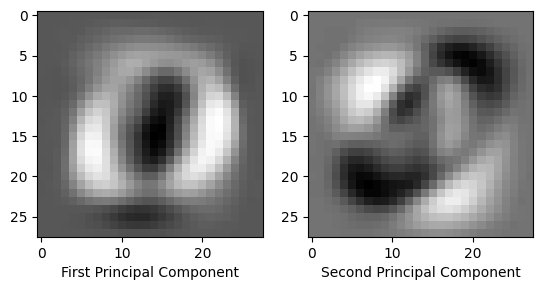

In [377]:
from sklearn.decomposition import PCA

# Let's find the first 2 PCA components
num_components = 2
pca = PCA(num_components).fit(train_images)

# Reshape so they resemble images and we can print them
eigen_mnist = pca.components_.reshape(num_components, img_rows, img_cols)

# Show the reshaped principal components
f, ax = plt.subplots(1,2)
ax[0].imshow(eigen_mnist[0], cmap='gray')
ax[0].set_xlabel('First Principal Component')
ax[1].imshow(eigen_mnist[1], cmap='gray')
ax[1].set_xlabel('Second Principal Component')

In [378]:
# Print the variance explained by those components
pca.explained_variance_

array([40.487637, 29.241697], dtype=float32)

Comment on the visualization in relation to the variance explained by only keeping the two principal components:
<div class='alert alert-block alert-warning'>
            Answer:</div>

The visualization of the first two principal components highlights the most significant patterns in the data, but it does not account for all the variability in the dataset. These two components explain approximately 69.7% of the total variance, leaving around 30.27% unaccounted for. To capture more of the dataset's variance and gain a deeper understanding of its structure, additional principal components or alternative techniques may be necessary.

**Bonus**

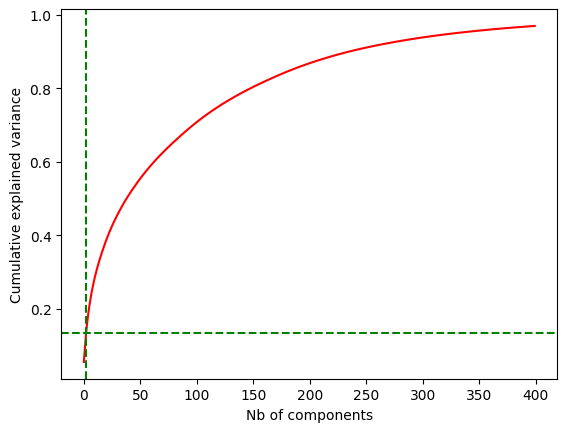

In [379]:
pca = PCA(n_components=400).fit(train_images)

# compute the cumulative explained variance
cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explained_variance, color='red')
plt.xlabel('Nb of components')
plt.ylabel('Cumulative explained variance')
#plot the 2 first components
plt.axvline(x=2, color='g', linestyle='--')
plt.axhline(y=cum_explained_variance[2], color='g', linestyle='--')

plt.show()

### Implementing the Autoencoder with Keras

In [380]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD

Now, we will use Keras to implement the autoencoder. You can take a look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf) for some basic commands to use keras.

In this first case, we implement a **simple linear autoencoder**. Build it in order to have the same capacity as the PCA decomposition (2 hidden dimensions !) we made just above. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [381]:
# Input layer
input_layer = Input(shape=(img_rows*img_cols,), name='input_layer')

# Encoding layer
latent_view = Dense(num_components, name= 'latent_view')(input_layer)

# Decoding layer
output_layer = Dense(img_rows*img_cols, name = 'output_layer', activation='sigmoid')(latent_view)

ae_model = Model(input_layer, output_layer, name='ae_model')
ae_model.summary()

Model: "ae_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_view (Dense)             │ (None, 2)              │         1,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 784)            │         2,352 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,922 (15.32 KB)

 Trainable params: 3,922 (15.32 KB)

 Non-trainable params: 0 (0.00 B)

What loss shoud we use ? Choose the usual one and import it directly from Keras. You can use a simple ```SGD``` optimizer, and then compile the model; finally, train it to rebuild images from the original examples. 
<div class='alert alert-block alert-info'>
            Code:</div>

In autoencoders, a commonly used loss function for reconstructing images from the original examples is the mean squared error (MSE) loss. It calculates the mean squared difference between the input and output images, with the goal of minimizing the reconstruction error.

In [382]:
from tensorflow.keras.losses import MeanSquaredError
loss = MeanSquaredError()

optimizer = SGD(learning_rate=1e-1) 
ae_model.compile(optimizer=optimizer, loss=loss) 

batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model.fit(train_images,
                       train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(test_images, test_images))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1663 - val_loss: 1.1590
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1489 - val_loss: 1.1516
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1576 - val_loss: 1.1358
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1331 - val_loss: 1.1087
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1097 - val_loss: 1.0817
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0643 - val_loss: 1.0621
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0605 - val_loss: 1.0476
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0520 - val_loss: 1.0349
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0519 - val_loss: 1.0216
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0081 - val_loss: 1.0061


Assuming that the name of your layer (obtained through the command ```model.summary()```) is ```'layer'```, here is the way to obtained the weights. Visualize the weights of the encoder and compare them to the two components obtained through the PCA.

In [383]:
weights, bias = ae_model.get_layer('latent_view').get_weights()
print(weights.shape, bias.shape)

(784, 2) (2,)


<div class='alert alert-block alert-info'>
            Code:</div>

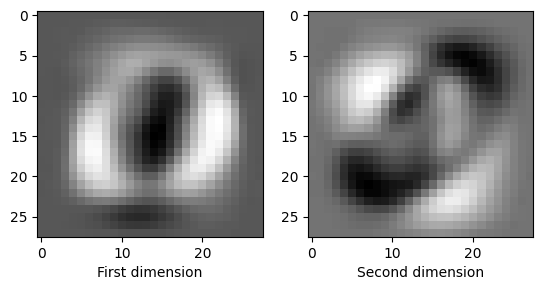

In [384]:
# Show the two dimensions of the encoder, in a similar manner to the principal components
# (after reshaping them as images !)

eigen_ae = weights.reshape((num_components, img_rows, img_cols))
f, ax = plt.subplots(1,2)
ax[0].imshow(eigen_mnist[0], cmap='gray')
ax[0].set_xlabel('First dimension')
ax[1].imshow(eigen_mnist[1], cmap='gray')
ax[1].set_xlabel('Second dimension')
plt.show()

Now, visualize the images rebuilt by the network !
<div class='alert alert-block alert-info'>
            Code:</div>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
(5, 784)


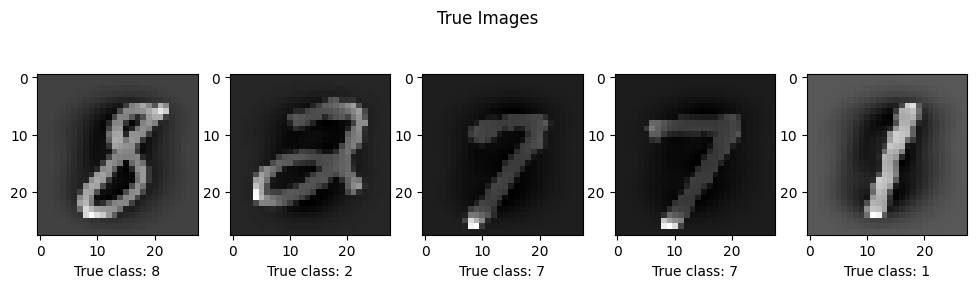

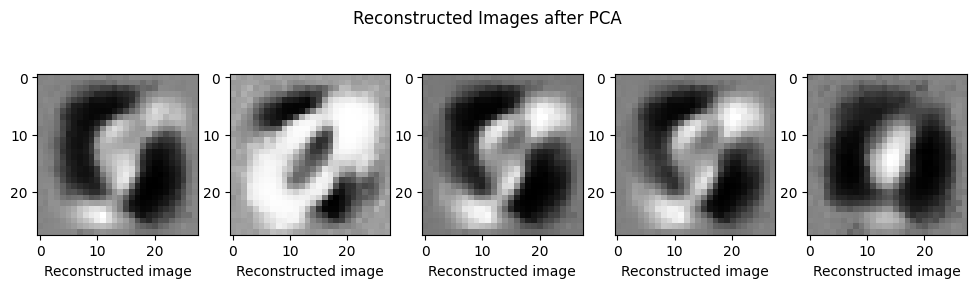

In [385]:
# Select a few images at random: look from n
n = np.random.randint(0,len(test_images)-5)

# Plot a few images from n  
f, ax = plt.subplots(1,5, figsize=(12, 3))
f.suptitle('True Images')
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(test_images[a].reshape((img_rows,img_cols)), cmap='gray')
    ax[i].set_xlabel('True class: ' + str(np.argmax(test_labels[a])))
# Get the prediction from the model 
prediction = ae_model.predict(test_images[n:n+5])
print(prediction.shape)

# ... and plot them 
f, ax = plt.subplots(1,5, figsize=(12, 3))
f.suptitle('Reconstructed Images after PCA')
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(prediction[a-n].reshape((img_rows,img_cols)), cmap='gray')
    ax[i].set_xlabel('Reconstructed image')

Do the same ( = build a new model) with a latent dimension that is largely higher than 2. Compare the visualizations and the images that are rebuilt. 
<div class='alert alert-block alert-info'>
            Code:</div>

Model: "ae_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_view (Dense)             │ (None, 20)             │        15,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 784)            │        16,464 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,164 (125.64 KB)

 Trainable params: 32,164 (125.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1977 - val_loss: 1.1548
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1379 - val_loss: 1.1323
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1198 - val_loss: 1.0935
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0712 - val_loss: 1.0573
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0278 - val_loss: 1.0270
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0081 - val_loss: 0.9992
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9961 - val_loss: 0.9708
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9670 - val_loss: 0.9392
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9399 - val_loss: 0.9034
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8916 - val_loss: 0.8664
(784, 20) (20,)


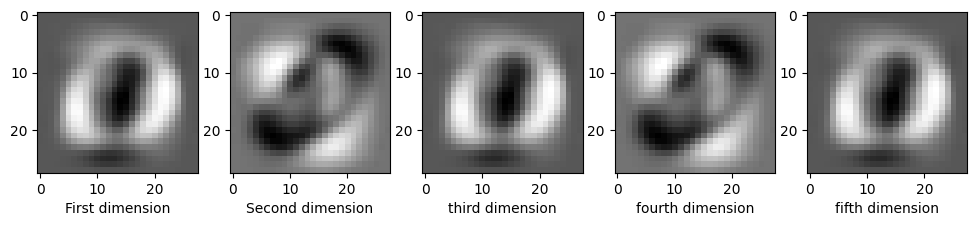

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
(5, 784)


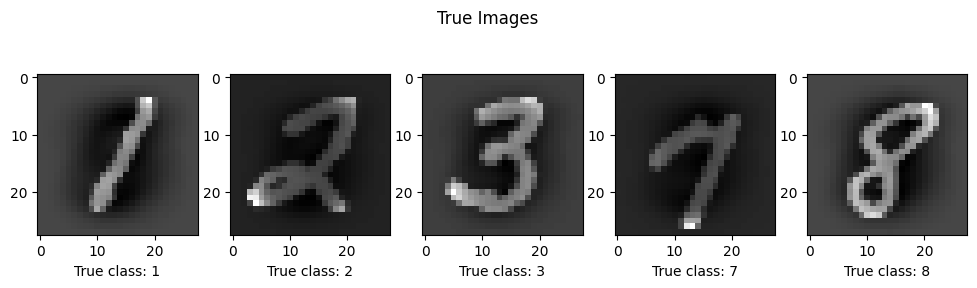

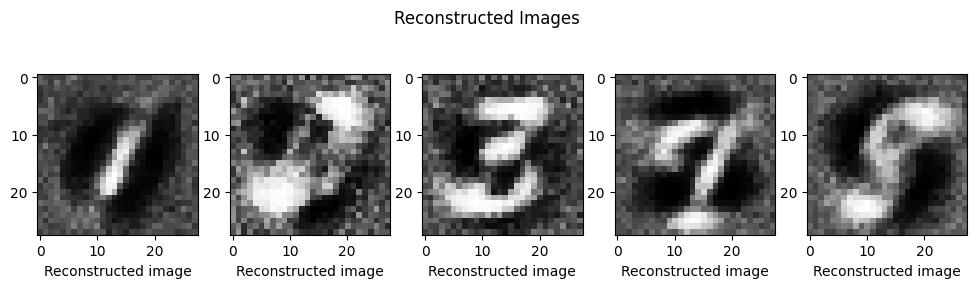

In [386]:
num_components = 20

# Input layer
input_layer = Input(shape=(img_rows*img_cols,), name='input_layer')

# Encoding layer
latent_view = Dense(num_components, name= 'latent_view')(input_layer)

# Decoding layer
output_layer = Dense(img_rows*img_cols, name = 'output_layer', activation='sigmoid')(latent_view)

ae_model = Model(input_layer, output_layer, name='ae_model')
ae_model.summary()

loss = MeanSquaredError()

optimizer = SGD(learning_rate=1e-1) 
ae_model.compile(optimizer=optimizer, loss=loss) 

batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model.fit(train_images,
                       train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(test_images, test_images))

weights, bias = ae_model.get_layer('latent_view').get_weights()
print(weights.shape, bias.shape)

# Show the two dimensions of the encoder, in a similar manner to the principal components
# (after reshaping them as images !)

eigen_ae = weights.reshape((num_components, img_rows, img_cols))
f, ax = plt.subplots(1,5, figsize=(12, 3))
ax[0].imshow(eigen_mnist[0], cmap='gray')
ax[0].set_xlabel('First dimension')
ax[1].imshow(eigen_mnist[1], cmap='gray')
ax[1].set_xlabel('Second dimension')
ax[2].imshow(eigen_mnist[0], cmap='gray')
ax[2].set_xlabel('third dimension')
ax[3].imshow(eigen_mnist[1], cmap='gray')
ax[3].set_xlabel('fourth dimension')
ax[4].imshow(eigen_mnist[0], cmap='gray')
ax[4].set_xlabel('fifth dimension')
plt.show()

# Select a few images at random: look from n
n = np.random.randint(0,len(test_images)-5)

# Plot a few images from n  
f, ax = plt.subplots(1,5, figsize=(12, 3))
f.suptitle('True Images')
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(test_images[a].reshape((img_rows,img_cols)), cmap='gray')
    ax[i].set_xlabel('True class: ' + str(np.argmax(test_labels[a])))
# Get the prediction from the model 
prediction = ae_model.predict(test_images[n:n+5])
print(prediction.shape)

# ... and plot them 
f, ax = plt.subplots(1,5, figsize=(12, 3))
f.suptitle('Reconstructed Images')
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(prediction[a-n].reshape((img_rows,img_cols)), cmap='gray')
    ax[i].set_xlabel('Reconstructed image')

### De-noising Autoencoder

Now, we can implement a **de-noising autoencoder**. The following function will transform an array of images by adding it random noise. Create a new autoencoder model, this time with **more layers** and **non-linear activations** (like the ReLU) and train it to rebuild the de-noised images. Display some testing images, with noise, and re-built.

In [387]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return noisy_array

In [388]:
# Create a copy of the data with added noise
noisy_train_images = noise(train_images)
noisy_test_images = noise(test_images)

<div class='alert alert-block alert-info'>
            Code:</div>

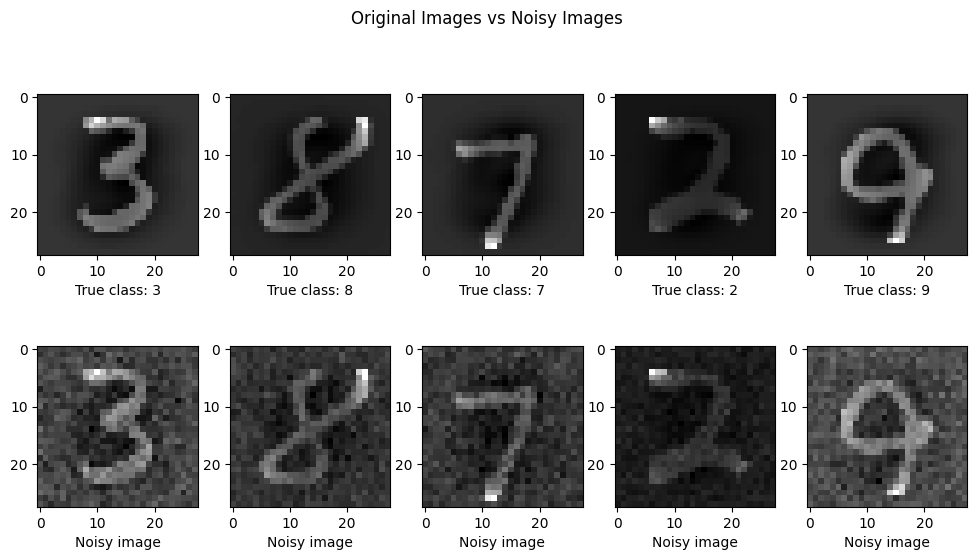

Model: "denoising_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded1 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded2 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded3 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded4 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded1 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded2 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded3 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded4 (Dense)                │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 489,136 (1.87 MB)

 Trainable params: 489,136 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.9373 - val_loss: 0.8452
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.8085 - val_loss: 0.7445
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7221 - val_loss: 0.7234
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7176 - val_loss: 0.7114
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6876 - val_loss: 0.7033
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6864 - val_loss: 0.6974
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7170 - val_loss: 0.6924
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6768 - val_loss: 0.6901
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6703 - val_loss: 0.6872
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6910 - val_loss: 0.6853
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6735 - val_loss: 0.6833
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/ste

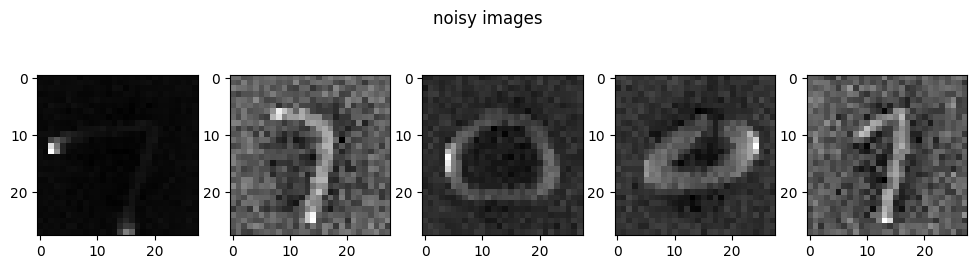

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


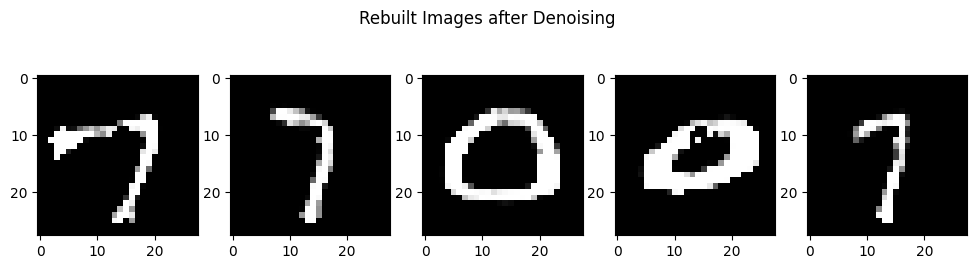

dict_keys(['loss', 'val_loss'])


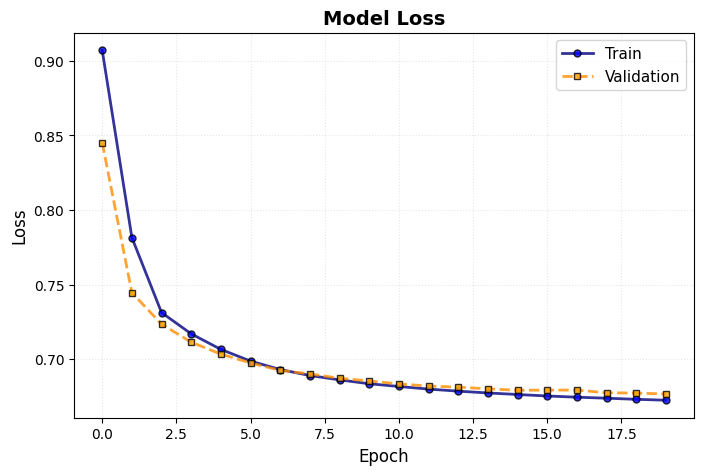

In [392]:
# Visualize some of the images with noise against the originals
n = np.random.randint(0,len(test_images)-5)
f, ax = plt.subplots(2,5, figsize=(12, 6))
f.suptitle('Original Images vs Noisy Images')
for i,a in enumerate(range(n,n+5)):
    ax[0,i].imshow(test_images[a].reshape((img_rows,img_cols)), cmap='gray')
    ax[0,i].set_xlabel('True class: ' + str(np.argmax(test_labels[a])))
    ax[1,i].imshow(noisy_test_images[a].reshape((img_rows,img_cols)), cmap='gray')
    ax[1,i].set_xlabel('Noisy image')
plt.show()


# Build a new model with more layers and Relu activations
input_layer = Input(shape=(img_rows*img_cols,), name='input_layer')

# Encoding layers
encoded = Dense(256, activation='relu', name='encoded1')(input_layer)
encoded = Dense(128, activation='relu', name='encoded2')(encoded)
encoded = Dense(64, activation='relu', name='encoded3')(encoded)
encoded = Dense(32, activation='relu', name='encoded4')(encoded)

# Decoding layers
decoded = Dense(64, activation='relu', name='decoded1')(encoded)
decoded = Dense(128, activation='relu', name='decoded2')(decoded)
decoded = Dense(256, activation='relu', name='decoded3')(decoded)
decoded = Dense(img_rows*img_cols, activation='sigmoid', name='decoded4')(decoded)

denoising_model = Model(input_layer, decoded, name='denoising_model')
denoising_model.summary()

# Compile it but here, use noised data as inputs !

loss = MeanSquaredError()
optimizer = SGD(learning_rate=1e-1) 
denoising_model.compile(optimizer='adam', loss=loss) #we use adam optimizer instead of SGD here in order to speed up the training!

batch_size = 256
epochs = 20
# RECALL that the target data must nnot be noisy too, because we want to rebuild the original images.
history = denoising_model.fit(noisy_train_images, 
                        train_images,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1,
                        shuffle=True,
                        validation_data=(noisy_test_images, test_images))

# Visualize the images rebuilt by the model !

n = np.random.randint(0,len(test_images)-5)

f, ax = plt.subplots(1,5, figsize=(12, 3))
f.suptitle('noisy images')
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(noisy_test_images[a].reshape((img_rows,img_cols)), cmap='gray')
plt.show()


f, ax = plt.subplots(1,5, figsize=(12, 3))
f.suptitle('Rebuilt Images after Denoising')
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(denoising_model.predict(noisy_test_images[n:n+5])[i].reshape((img_rows,img_cols)), cmap='gray')
plt.show()

#plotting the training and validation loss
print(history.history.keys())
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train', color='navy', linestyle='-', linewidth=2, 
         marker='o', markersize=5, markerfacecolor='blue', markeredgecolor='black', alpha=0.8)
plt.plot(history.history['val_loss'], label='Validation', color='darkorange', linestyle='--', linewidth=2, 
         marker='s', markersize=5, markerfacecolor='orange', markeredgecolor='black', alpha=0.8)

plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(loc='upper right', fontsize=11)
plt.grid(alpha=0.3, linestyle='dotted')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

Assuming that we normalize the images to be in the 0-1 range, what other loss function could we use ?
<div class='alert alert-block alert-warning'>
            Answer:</div>

When images are normalized to the 0-1 range, they can be interpreted as probability distributions, with each pixel value representing the likelihood of a specific intensity level. In this probabilistic framework, Maximum Likelihood Estimation (MLE) is a natural choice for training autoencoders, as it seeks to maximize the likelihood of generating the observed data under the given model. Consequently, the log loss can be used as an appropriate loss function in this case.